<a href="https://colab.research.google.com/github/Igoresv/Aprendizado-supervisionado/blob/main/rn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Para classificar a qualidade do vinho com base em suas características, podemos utilizar uma Rede Neural Artificial (RNA). Primeiro, coletamos os dados sobre os vinhos, incluindo atributos como teor alcoólico, acidez e pH. Em seguida, dividimos os dados em um conjunto de treinamento e um conjunto de teste.

Em seguida, construímos um modelo de RNA usando a biblioteca TensorFlow e treinamos o modelo com o conjunto de treinamento. Configuramos a RNA com camadas densamente conectadas e usamos a função de ativação "relu" para as camadas intermediárias. Para a camada de saída, usamos a função de ativação "sigmoid" para obter probabilidades de classificação binária (vinho bom ou ruim).

Após treinar o modelo de RNA, podemos avaliar seu desempenho fazendo previsões para os dados de teste e comparando-os com as etiquetas reais. Os resultados mostraram uma acurácia de 0,76, precisão de 0,81, recall de 0,80 e F1-score de 0,80. Essas métricas indicam o quão bem o modelo se saiu na classificação da qualidade do vinho.

Além disso, plotamos a matriz de confusão para visualizar a distribuição das previsões e rótulos reais. A matriz de confusão mostrou o número de verdadeiros positivos, verdadeiros negativos, falsos positivos e falsos negativos.

Também foi gerado um histograma da saída da RNA para analisar a distribuição das probabilidades previstas para cada instância.

No geral, os resultados indicam que o modelo de RNA obteve um desempenho razoável na classificação da qualidade do vinho com base nas características fornecidas. A acurácia, precisão, recall e F1-score demonstram que o modelo pode distinguir efetivamente entre vinhos bons e ruins. No entanto, análises e ajustes adicionais no modelo podem ser necessários para melhorar seu desempenho.

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    auc,
    RocCurveDisplay,
    confusion_matrix,
    classification_report
)
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

In [5]:
wines = pd.read_csv('/content/winequalityN.csv')
wines.info()

removed_rows = (len(wines.dropna()) / len(wines)) - 1
print(f"Remover os valores com NaN diminui {abs(removed_rows) * 100:.2f}% da base original de vinhos.")
wines = wines.dropna()

wines['opinion'] = [0 if quality < 6 else 1 for quality in wines['quality']]

white_wines = wines[wines.type == 'white'].reset_index().drop('index', axis=1)

# Organizando dados para ficar as variáveis contínuas
white_wines = white_wines.drop(columns=['type', 'quality'])
features = white_wines.columns.drop('opinion')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB
Remover os valores com NaN diminui 0.52% da base original de vi

array([[<Axes: title={'center': 'fixed acidity'}>,
        <Axes: title={'center': 'volatile acidity'}>,
        <Axes: title={'center': 'citric acid'}>],
       [<Axes: title={'center': 'residual sugar'}>,
        <Axes: title={'center': 'chlorides'}>,
        <Axes: title={'center': 'free sulfur dioxide'}>],
       [<Axes: title={'center': 'total sulfur dioxide'}>,
        <Axes: title={'center': 'density'}>,
        <Axes: title={'center': 'pH'}>],
       [<Axes: title={'center': 'sulphates'}>,
        <Axes: title={'center': 'alcohol'}>, <Axes: >]], dtype=object)

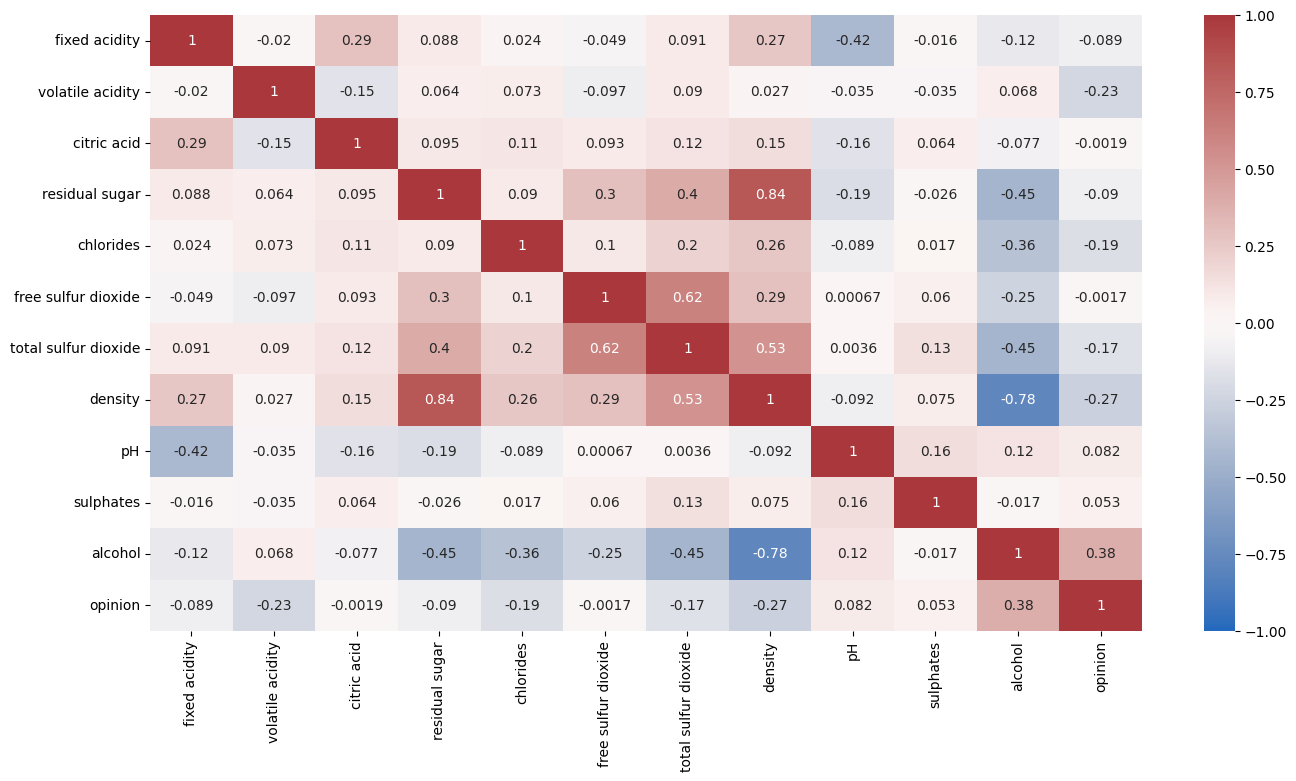

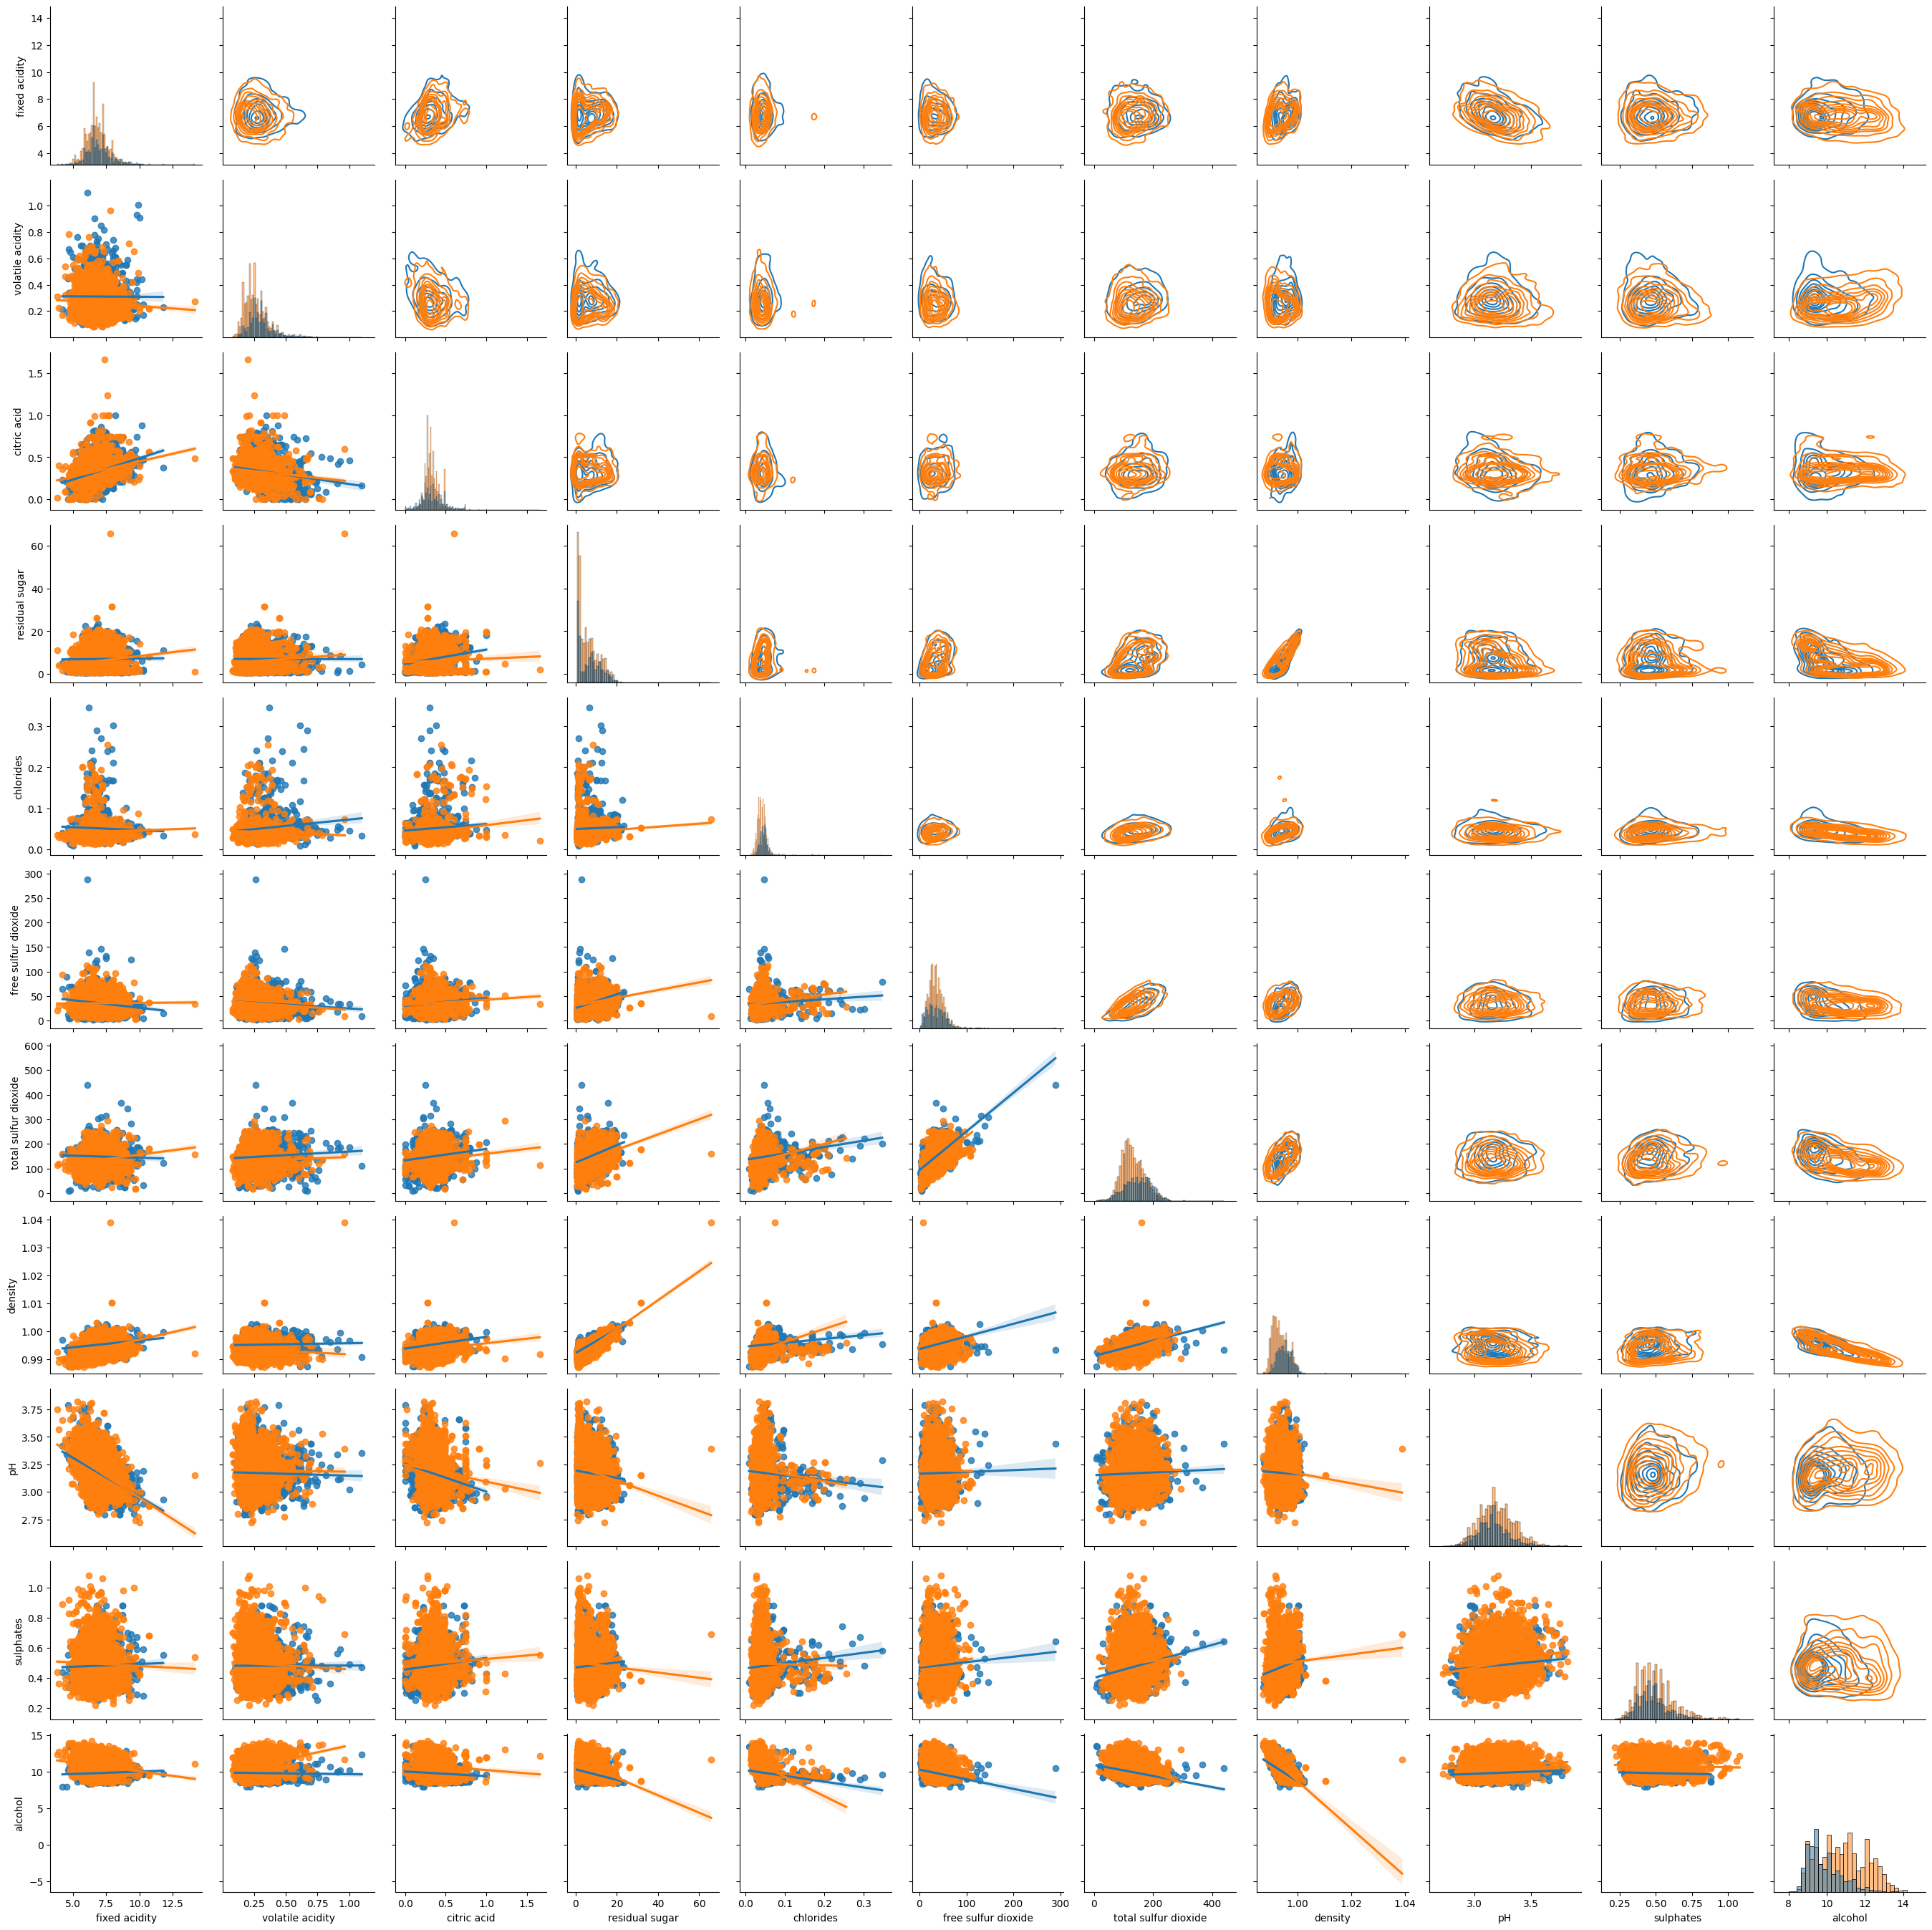

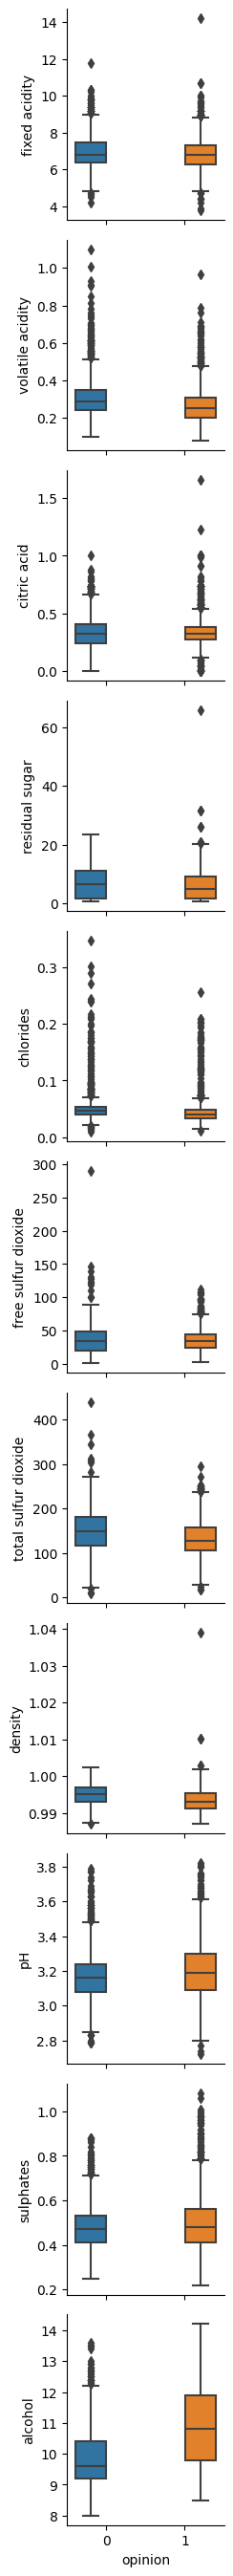

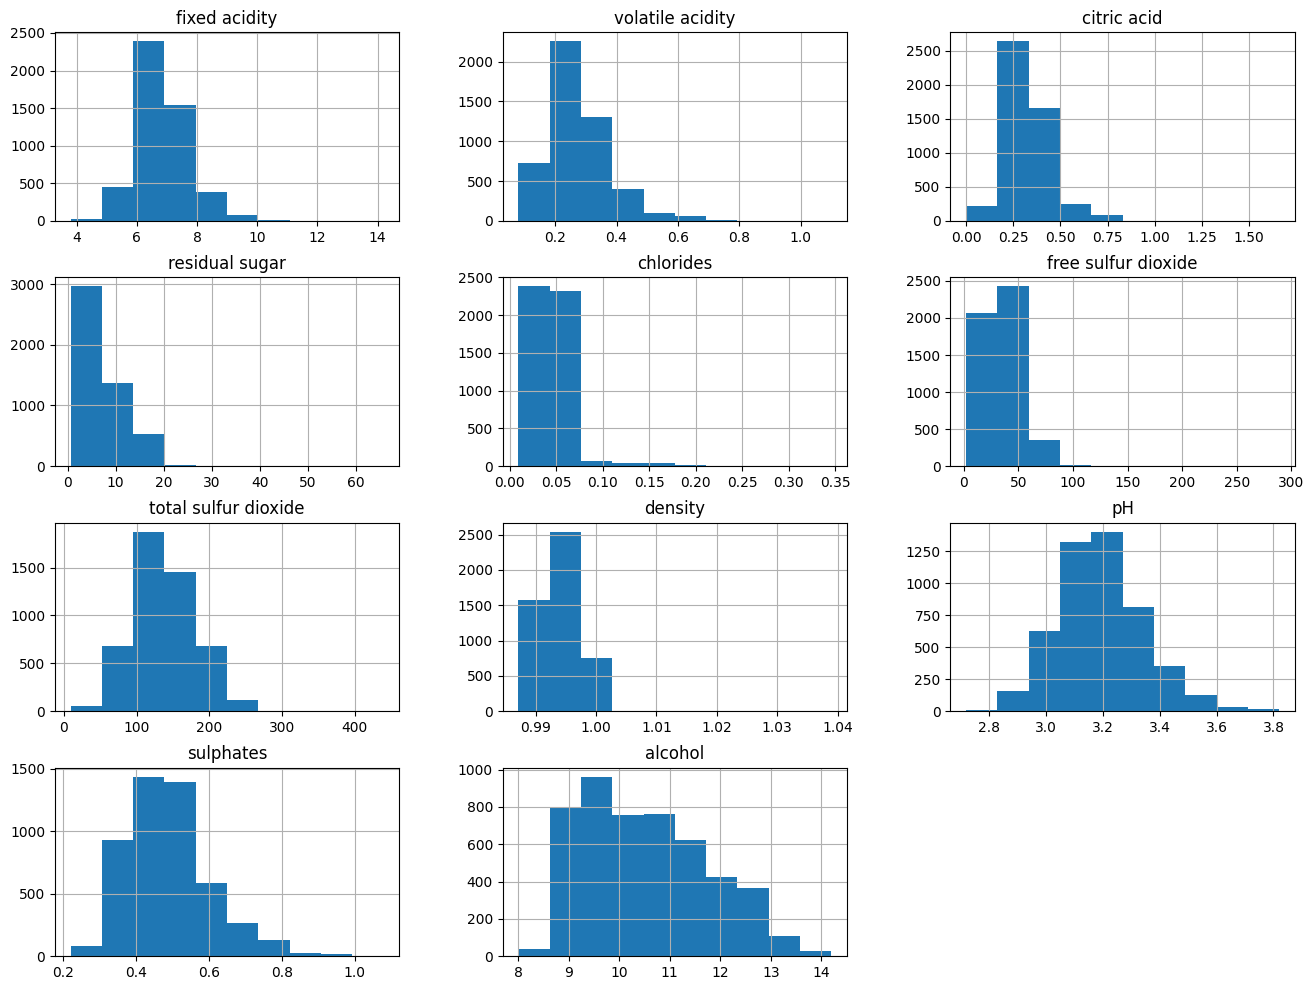

In [6]:
# Analisando as correlações entre as variáveis contínuas
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.heatmap(white_wines.corr(), vmin=-1, vmax=1, annot=True, ax=ax, cmap='vlag')

g = sns.PairGrid(white_wines, hue='opinion')
g.map_lower(sns.regplot)
g.map_diag(sns.histplot)
g.map_upper(sns.kdeplot)

# Checando Outliers
g = sns.PairGrid(white_wines, hue='opinion', x_vars='opinion')
g.map(sns.boxplot)

# Distribuição das variáveis conforme ponto 2B
white_wines[features].hist(figsize=(16, 12))


array([[<Axes: title={'center': 'fixed acidity'}>,
        <Axes: title={'center': 'volatile acidity'}>,
        <Axes: title={'center': 'citric acid'}>],
       [<Axes: title={'center': 'residual sugar'}>,
        <Axes: title={'center': 'chlorides'}>,
        <Axes: title={'center': 'free sulfur dioxide'}>],
       [<Axes: title={'center': 'total sulfur dioxide'}>,
        <Axes: title={'center': 'density'}>,
        <Axes: title={'center': 'pH'}>],
       [<Axes: title={'center': 'sulphates'}>,
        <Axes: title={'center': 'alcohol'}>, <Axes: >]], dtype=object)

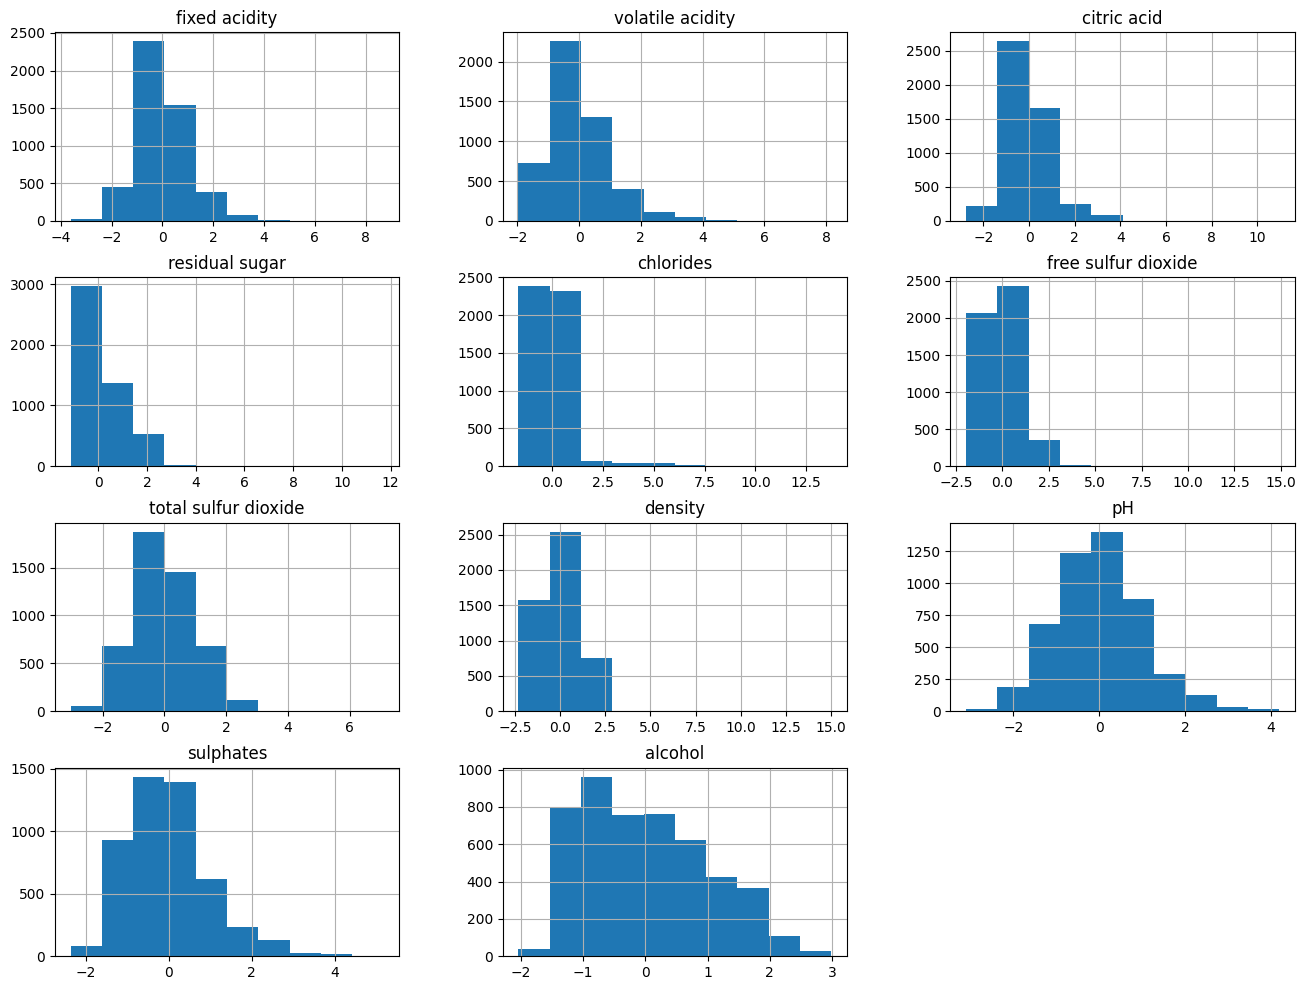

In [7]:
# Escalonando com StandardScaler (ss)
df_ss = white_wines.copy()
ss = StandardScaler()
df_ss[features] = ss.fit_transform(white_wines[features])
df_ss[features].hist(figsize=(16, 12))


In [8]:
ax.axhline(y=0.95, color='r', linestyle='--')  # Linha representando 95% de variância explicada
ax.set_xticks(range(1, len(explained_variance_ratio) + 1))
ax.set_xticklabels(range(1, len(explained_variance_ratio) + 1))

ax.set_title('Pareto Chart - PCA')

# Formatando os eixos
ax.set_xlabel('Componentes Principais')
ax.set_ylabel('Variância Explicada Acumulada')
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))

# Imprimindo o número de componentes principais necessários para atingir 95% de variância explicada
n_components = np.where(explained_variance_ratio >= 0.95)[0][0] + 1
print(f"Número de componentes principais necessários para atingir 95% de variância explicada: {n_components}")

# Aplicando a transformação PCA nos dados
pca = PCA(n_components=n_components)
df_pca = pca.fit_transform(df_ss)

# Criando um novo DataFrame com os componentes principais
df_pca = pd.DataFrame(df_pca, columns=[f"PC{i+1}" for i in range(n_components)])
df_pca['opinion'] = white_wines['opinion']


Número de componentes principais necessários para atingir 95% de variância explicada: 9


In [9]:
# Dividindo os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(df_pca.drop('opinion', axis=1), df_pca['opinion'], test_size=0.2, random_state=42)


In [10]:
# Treinando e avaliando o modelo de Regressão Logística
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Regressão Logística:")
print(f"Acurácia: {accuracy:.2f}")
print(f"Precisão: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print()

# Treinando e avaliando o modelo de Árvore de Decisão
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Árvore de Decisão:")
print(f"Acurácia: {accuracy:.2f}")
print(f"Precisão: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print()

# Treinando e avaliando o modelo SVM
svm = SVC(probability=True)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("SVM:")
print(f"Acurácia: {accuracy:.2f}")
print(f"Precisão: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print()


Regressão Logística:
Acurácia: 0.83
Precisão: 0.85
Recall: 0.91
F1-Score: 0.88

Árvore de Decisão:
Acurácia: 0.83
Precisão: 0.87
Recall: 0.87
F1-Score: 0.87

SVM:
Acurácia: 0.85
Precisão: 0.86
Recall: 0.92
F1-Score: 0.89



SVM:
Acurácia: 0.85
Precisão: 0.86
Recall: 0.92
F1-Score: 0.89



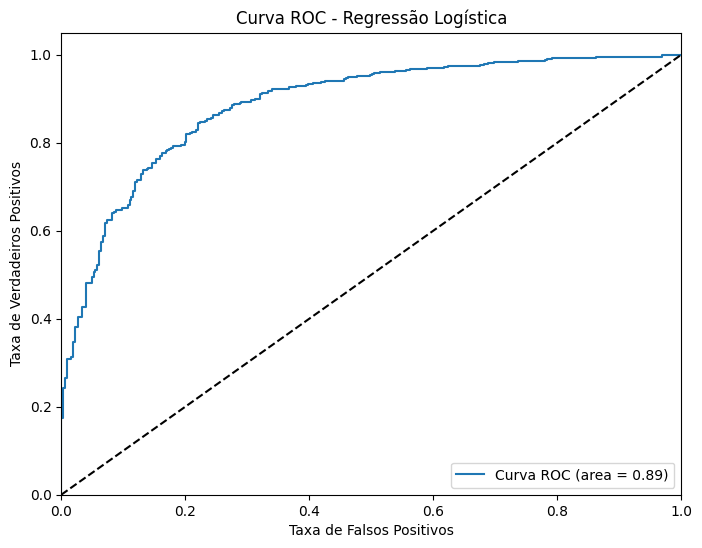

In [11]:
print("SVM:")
print(f"Acurácia: {accuracy:.2f}")
print(f"Precisão: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print()

# Plotando a curva ROC para a Regressão Logística
y_pred_proba = logreg.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='Curva ROC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - Regressão Logística')
plt.legend(loc="lower right")
plt.show()


In [15]:
# número de componentes principais necessários para atingir 95% de variância explicada
n_components = np.where(explained_variance_ratio >= 0.95)[0][0] + 1
print(f"Número de componentes principais necessários para atingir 95% de variância explicada: {n_components}")

# Aplicando a transformação PCA nos dados
pca = PCA(n_components=n_components)
df_pca = pca.fit_transform(df_ss)

# Criando um novo DataFrame com os componentes principais
df_pca = pd.DataFrame(df_pca, columns=[f"PC{i+1}" for i in range(n_components)])
df_pca['opinion'] = white_wines['opinion']


Número de componentes principais necessários para atingir 95% de variância explicada: 9


In [16]:
# Dividindo os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(df_pca.drop('opinion', axis=1), df_pca['opinion'], test_size=0.2, random_state=42)

# Treinando e avaliando o modelo de Regressão Logística
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Regressão Logística:")
print(f"Acurácia: {accuracy:.2f}")
print(f"Precisão: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print()


Regressão Logística:
Acurácia: 0.83
Precisão: 0.85
Recall: 0.91
F1-Score: 0.88



In [17]:
# Treinando e avaliando o modelo de Árvore de Decisão
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Árvore de Decisão:")
print(f"Acurácia: {accuracy:.2f}")
print(f"Precisão: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print()


Árvore de Decisão:
Acurácia: 0.83
Precisão: 0.87
Recall: 0.88
F1-Score: 0.88



In [18]:
# Treinando e avaliando o modelo SVM
svm = SVC(probability=True)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("SVM:")
print(f"Acurácia: {accuracy:.2f}")
print(f"Precisão: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print()


SVM:
Acurácia: 0.85
Precisão: 0.86
Recall: 0.92
F1-Score: 0.89



In [19]:
# Criando e treinando a rede neural
model = Sequential()
model.add(Dense(64, input_dim=n_components, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)




Epoch 1/10
122/122 [==============================] - 2s 2ms/step - loss: 0.5153 - accuracy: 0.7526
Epoch 2/10
122/122 [==============================] - 0s 2ms/step - loss: 0.4143 - accuracy: 0.8157
Epoch 3/10
122/122 [==============================] - 0s 2ms/step - loss: 0.3984 - accuracy: 0.8252
Epoch 4/10
122/122 [==============================] - 0s 2ms/step - loss: 0.3897 - accuracy: 0.8298
Epoch 5/10
122/122 [==============================] - 0s 2ms/step - loss: 0.3843 - accuracy: 0.8306
Epoch 6/10
122/122 [==============================] - 0s 2ms/step - loss: 0.3791 - accuracy: 0.8357
Epoch 7/10
122/122 [==============================] - 0s 2ms/step - loss: 0.3752 - accuracy: 0.8368
Epoch 8/10
122/122 [==============================] - 0s 2ms/step - loss: 0.3697 - accuracy: 0.8391
Epoch 9/10
122/122 [==============================] - 0s 2ms/step - loss: 0.3677 - accuracy: 0.8432
Epoch 10/10
122/122 [==============================] - 0s 2ms/step - loss: 0.3628 - accuracy: 0.8437

In [21]:
# Avaliando o desempenho da rede neural
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Rede Neural:")
print(f"Acurácia: {accuracy:.2f}")
print(f"Precisão: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print()


31/31 [==============================] - 0s 1ms/step
Rede Neural:
Acurácia: 0.84
Precisão: 0.86
Recall: 0.91
F1-Score: 0.89



Epoch 1/10
122/122 [==============================] - 1s 4ms/step - loss: 0.5116 - accuracy: 0.7513 - val_loss: 0.4170 - val_accuracy: 0.8183
Epoch 2/10
122/122 [==============================] - 0s 3ms/step - loss: 0.4124 - accuracy: 0.8144 - val_loss: 0.3865 - val_accuracy: 0.8388
Epoch 3/10
122/122 [==============================] - 0s 3ms/step - loss: 0.3971 - accuracy: 0.8208 - val_loss: 0.3773 - val_accuracy: 0.8398
Epoch 4/10
122/122 [==============================] - 0s 2ms/step - loss: 0.3863 - accuracy: 0.8275 - val_loss: 0.3755 - val_accuracy: 0.8347
Epoch 5/10
122/122 [==============================] - 0s 3ms/step - loss: 0.3786 - accuracy: 0.8332 - val_loss: 0.3683 - val_accuracy: 0.8501
Epoch 6/10
122/122 [==============================] - 0s 2ms/step - loss: 0.3728 - accuracy: 0.8360 - val_loss: 0.3652 - val_accuracy: 0.8542
Epoch 7/10
122/122 [==============================] - 0s 2ms/step - loss: 0.3683 - accuracy: 0.8370 - val_loss: 0.3630 - val_accuracy: 0.8511
Epoch 

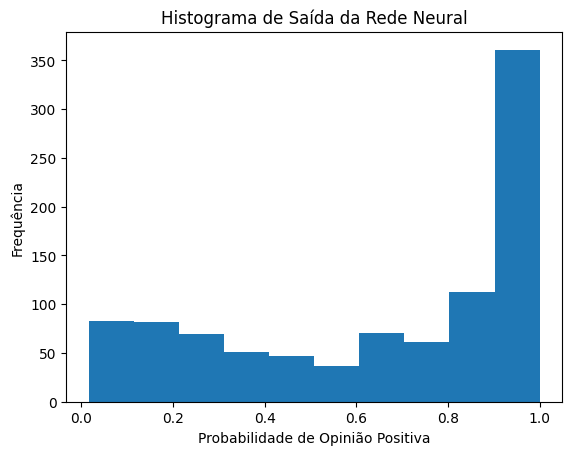

In [23]:
# Criando um modelo de Rede Neural Artificial
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(n_components,)))  # Adicionando a primeira camada densa
model.add(Dense(32, activation='relu'))  # Adicionando a segunda camada densa
model.add(Dense(1, activation='sigmoid'))  # Camada de saída

# Compilando o modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Treinando a Rede Neural
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Avaliando o desempenho da rede neural
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Rede Neural Artificial:")
print(f"Acurácia: {accuracy:.2f}")
print(f"Precisão: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print()


# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
print("Matriz de Confusão:")
print(cm)

# Histograma de Saída
y_pred_proba = model.predict(X_test)
plt.hist(y_pred_proba, bins=10)
plt.xlabel("Probabilidade de Opinião Positiva")
plt.ylabel("Frequência")
plt.title("Histograma de Saída da Rede Neural")

# Figuras de Mérito
classification_rep = classification_report(y_test, y_pred)
print("Figuras de Mérito:")
print(classification_rep)
